Vamos a hacer un Clustering jerárquico, para una temporada

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def preparar_datos_para_clustering(df, columnas_excluir=None, divisor=38):
    """
    Prepara un DataFrame para clustering jerárquico:
    - Filtra numéricas
    - Divide por un divisor (por defecto 38) Adaptar a la bundesliga
    - Aplica StandardScaler

    Parámetros:
    - df: DataFrame original
    - columnas_excluir: lista de columnas a mantener fuera (ID, etiquetas)
    - divisor: valor para normalizar (por defecto 38 partidos)

    Retorna:
    - df_escalado: array numpy listo para clustering
    - df_filtrado: DataFrame escalado con índice original
    """
    if columnas_excluir is None:
        columnas_excluir = []

    # Separar columnas excluidas
    df_excluir = df[columnas_excluir] if columnas_excluir else pd.DataFrame(index=df.index)

    # Seleccionar solo numéricas no excluidas
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns=columnas_excluir, errors='ignore')

    # Normalizar por divisor (por partido o por 90 minutos)
    df_normalizado = df_numeric / divisor

    # Escalar
    scaler = StandardScaler()
    df_escalado = scaler.fit_transform(df_normalizado)

    # Convertimos a DataFrame si quieres conservar estructura
    df_escalado_df = pd.DataFrame(df_escalado, index=df.index, columns=df_normalizado.columns)

    return df_escalado, df_escalado_df, df_normalizado


In [ ]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

def dendograma_jerarquico(X, metodo='ward', titulo='Dendograma jerárquico'):
    """
    Genera un dendrograma jerárquico
    - X: datos escalados
    - metodo: método de linkage (ward, complete, average, etc.)
    """
    plt.figure(figsize=(14, 6))
    linkage_matrix = sch.linkage(X, method=metodo)
    sch.dendrogram(linkage_matrix)
    plt.title(titulo)
    plt.xlabel('Observaciones')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()


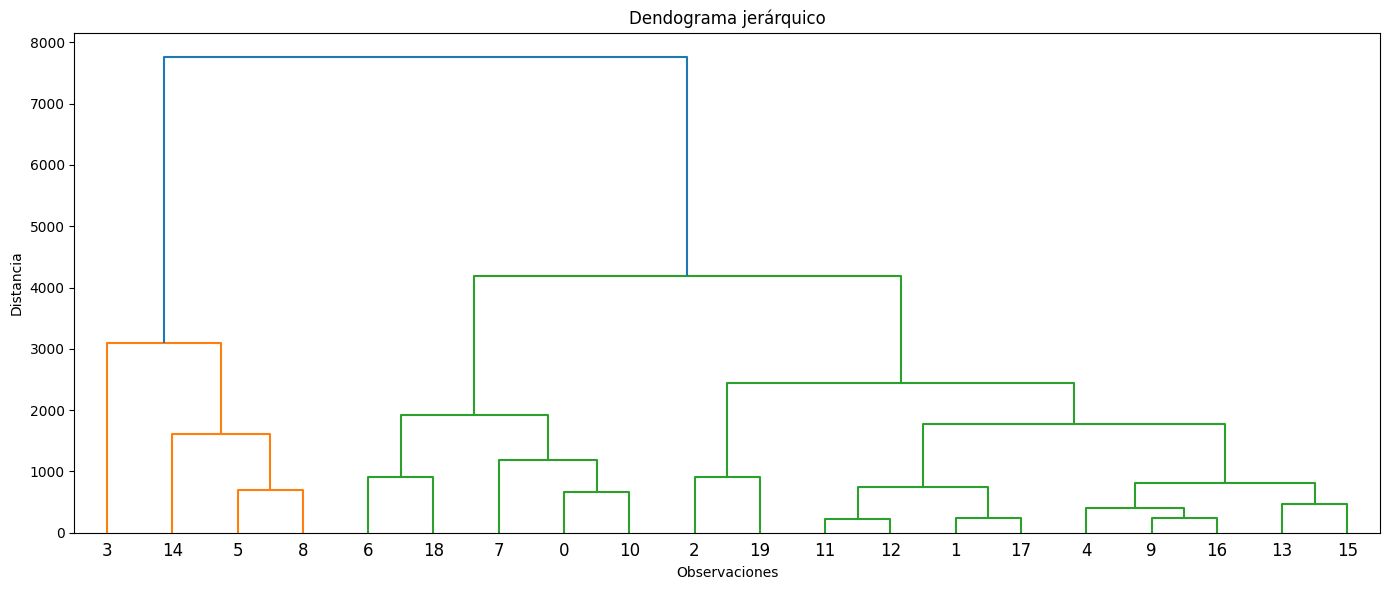

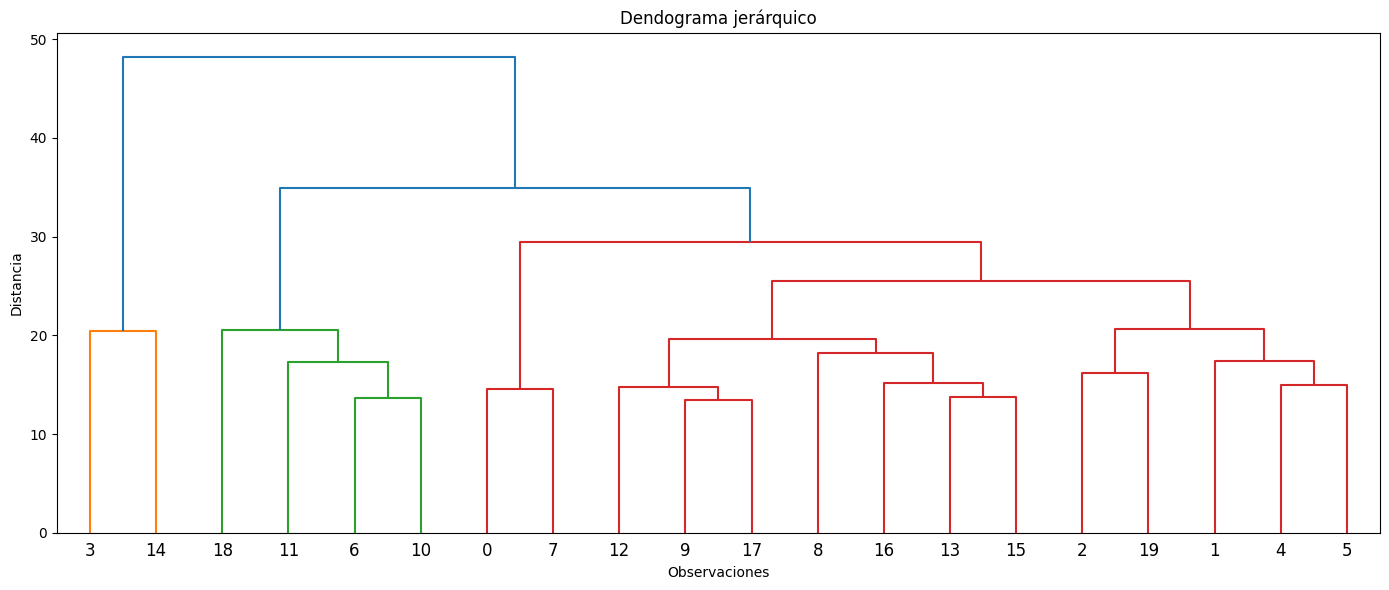

In [ ]:
# Cargar datos
df = pd.read_csv("../output/all_teams_all_metrics.csv")
df = df[df['Season'] == '2024-2025']  # Filtrar por temporada específica
# Preprocesar (excluyendo columnas no numéricas o IDs)
X, df_ready, X_90 = preparar_datos_para_clustering(df, columnas_excluir=["Squad", "Season"])

# Mostrar dendrograma
dendograma_jerarquico(X_90)
dendograma_jerarquico(X)

Añadimos nombre y temporada para cada equipo, buscando así una mejor identificación.

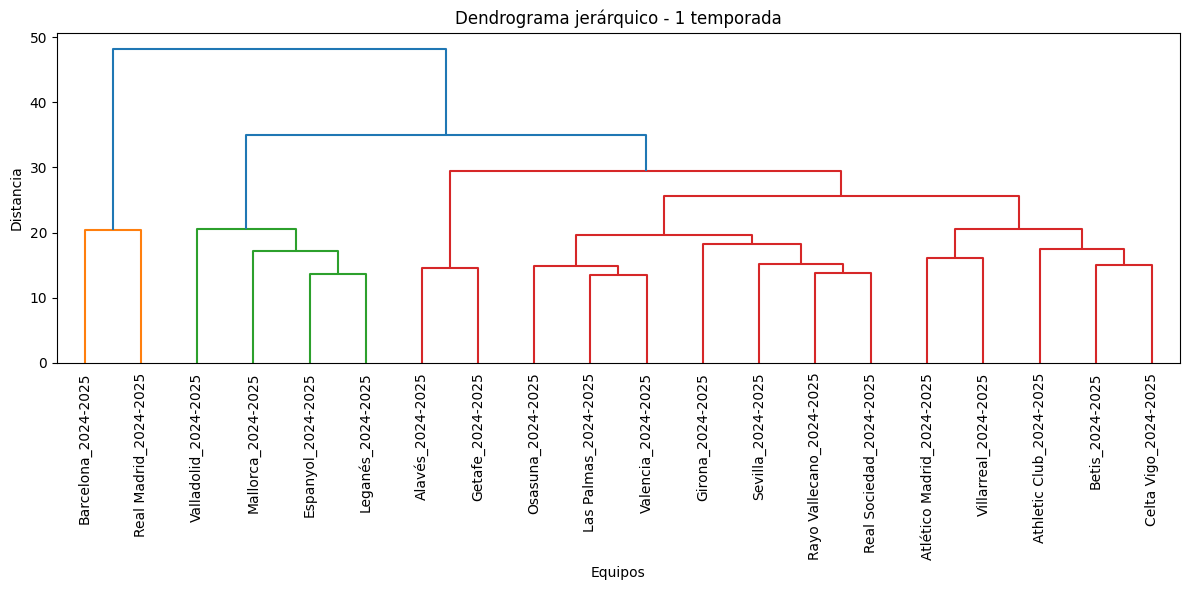

In [ ]:

df["Equipo_Temporada"] = df["Squad"] + "_" + df["Season"].astype(str)
plt.figure(figsize=(12, 6))
linkage_matrix = sch.linkage(X, method='ward')

sch.dendrogram(
    linkage_matrix,
    labels=df["Equipo_Temporada"].tolist(),
    leaf_rotation=90,
    leaf_font_size=10
)

plt.title("Dendrograma jerárquico - 1 temporada")
plt.xlabel("Equipos")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()

